In [1]:
!pip install -U PyYAML

In [2]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2
''
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/MILA/IFT6759/Project/src" #@param {type:"string"}
!ln -Ts "$folder" /content/src 2> /dev/null

# Add the assignment folder to Python path
if '/content/src' not in sys.path:
  sys.path.insert(0, '/content/src')

# Install requirements
#!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [4]:
import argparse
import logging
import os
import torch
import yaml
import numpy as np
import pickle
import logging
import torch.nn.functional as F


In [5]:
config_name = "Sup_Config0"

with open(f"./src/Config/{config_name}.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


In [6]:
device = "cuda"
task = config["task"]
data_file = config["data"]
model_file = config["model"]
augment_file = config["augment"]
augment_strength = config["aug_strength"]
eval_file = config["eval"]
batch_size = config["batch_size"]
learn_rate = config["learning_rate"]
epoch = config["epoch"]
optimizer = config["optimizer"]
momentum = config["momentum"]
weight_decay = config["weight_decay"]
seed = config["seed"]
epoch = config["epoch"]

In [7]:
config

{'aug_strength': None,
 'augment': None,
 'batch_size': 250,
 'data': 'cifar10',
 'epoch': 160,
 'eval': 'Acc',
 'learning_rate': 0.01,
 'model': 'resnet20',
 'momentum': 0.9,
 'optimizer': 'sgd',
 'seed': 6759,
 'task': 'super',
 'weight_decay': 0.0005}

In [8]:
# logging.info(f"==========Dataset: {data_file}==========")
print(f"==========Dataset: {data_file}==========")
data_file_path = f"Data.{data_file}"
_temp = __import__(name=data_file_path, fromlist=['Data_Load'])
Data_Load = _temp.Data_Load

==========Dataset: cifar10==========


In [9]:
if augment_file == None:
    print("No augmentation method selected")
else:
    Aug = []
    for i in range(len(augment_file)):
        # logging.info(f"==========Augmentation Methods: {augment_file[i]}, with a strength value of {augment_strength[i]}==========")
        print(f"==========Augmentation Methods: {augment_file[i]}, with a strength value of {augment_strength[i]}==========")
        augment_file_path = f"Augmentation.{augment_file[i]}"
        _temp = __import__(name=augment_file_path, fromlist=['Aug'])
        Aug.append(_temp.Aug)

No augmentation method selected


In [10]:
# Importing the model class
# logging.info(f"==========Model Selected: {model_file}==========")
print(f"==========Model Selected: {model_file}==========")
model_file_path = f"Model.{model_file}"
_temp = __import__(name=model_file_path, fromlist=['ModelClass'])
ModelClass = _temp.ModelClass

==========Model Selected: resnet20==========


In [11]:
# Importing the evaluation methods
logging.info(f"==========Evaluation Method: {eval_file}==========")
eval_file_path = f"Evaluation.{eval_file}"
_temp = __import__(name=eval_file_path, fromlist=['Eval'])
Eval = _temp.Eval  

INFO:root:==========Evaluation Method: Acc==========


In [12]:
labelledloader, unlabelledloader, validloader, testloader = Data_Load(task = task, batch_size = batch_size, seed = seed)
logging.info("Dataloader ready")    

Files already downloaded and verified
Files already downloaded and verified


INFO:root:Data Extracted
INFO:root:Data split for supervised learning task
INFO:root:Data Loaded
INFO:root:Dataloader ready


In [13]:
if (task == "super"):
  torch.manual_seed(seed)
  np.random.seed(seed)

  train_tot_accs, valid_tot_accs = [], []
  train_tot_losses, valid_tot_losses = [], []

  Model = ModelClass(optimizer=optimizer,lr=learn_rate,weight_decay=weight_decay,momentum=momentum)
  Model = Model.to(device=device)

  for ep in range(epoch):
      
      # logging.info(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
      print(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
      train_accs, valid_accs = [], []
      train_losses, valid_losses = [], []
      
      if ep == epoch/2:
        learn_rate = learn_rate/10
        print(f"Update Learning Rate: {learn_rate}")
        Model.update_lr(learn_rate)

      if ep == 3*epoch/4:
        learn_rate = learn_rate/10
        print(f"Update Learning Rate: {learn_rate}")
        Model.update_lr(learn_rate)

      for idx, batch in enumerate(labelledloader):
          data, target = batch
          data = data.to(device=device)
          labels = F.one_hot(target, num_classes = 10).float().to(device=device)

          batch_len = data.shape[0]
          aug_num = []
          
          if augment_file != None:

            for i in range(len(augment_strength)):
              aug_num.append(augment_strength[i]*batch_len)
            
            if len(aug_num) != 1:
              aug_num = torch.tensor(aug_num)
              aug_ind = torch.cumsum(aug_num,0).int()
            else:
              aug_ind = aug_num

            for i in range(len(Aug)):
              if i == 0:
                temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
                Aug_data = temp_Aug
                Aug_labels = temp_label
              else:
                temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
                Aug_data = torch.cat((Aug_data, temp_Aug), 0)
                Aug_labels = torch.cat((Aug_labels, temp_label), 0)

          else:
            # Aug_data = torch.cat((data,data,data,data),0)
            # Aug_labels = torch.cat((labels,labels,labels,labels),0)
            # Aug_data = data
            # Aug_labels = labels
            Aug_data = torch.cat((data,data),0)
            Aug_labels = torch.cat((labels,labels),0)

          #print(Aug_data.shape)

          acc, loss = Model.train_sup_up(Aug_data,Aug_labels)
          train_accs.append(acc)
          train_losses.append(loss)
      
      train_tot_accs.append(sum(train_accs)/len(train_accs))
      train_tot_losses.append(sum(train_losses)/len(train_losses))
          
      # logging.info(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")    
      print(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")

      for idx, batch in enumerate(validloader):
          data, target = batch
          data = data.to(device=device)
          labels = F.one_hot(target, num_classes = 10).float().to(device=device)
          acc, loss = Model.evaluation(data,labels)
          valid_accs.append(acc)
          valid_losses.append(loss)
          
      valid_tot_accs.append(sum(valid_accs)/len(valid_accs))
      valid_tot_losses.append(sum(valid_losses)/len(valid_losses))
      
      # logging.info(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")    
      print(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")
  
  print(f"==========Max Training Accuracy: {torch.max(torch.tensor(train_tot_accs)):.3f} , Min Training Loss: {torch.min(torch.tensor(train_tot_losses)):.3f}==========")    
  print(f"==========Max Validation Accuracy: {torch.max(torch.tensor(valid_tot_accs)):.3f} , Min Validation Loss: {torch.min(torch.tensor(valid_tot_losses)):.3f}==========")

==========Supervised Learning Epoch Number: 1/160==========
==========Training Accuracy: 0.413 , Training Loss: 1.582==========
==========Validation Accuracy: 0.450 , Validation Loss: 1.515==========
==========Supervised Learning Epoch Number: 2/160==========
==========Training Accuracy: 0.592 , Training Loss: 1.124==========
==========Validation Accuracy: 0.614 , Validation Loss: 1.086==========
==========Supervised Learning Epoch Number: 3/160==========
==========Training Accuracy: 0.678 , Training Loss: 0.899==========
==========Validation Accuracy: 0.624 , Validation Loss: 1.056==========
==========Supervised Learning Epoch Number: 4/160==========
==========Training Accuracy: 0.732 , Training Loss: 0.760==========
==========Validation Accuracy: 0.639 , Validation Loss: 1.053==========
==========Supervised Learning Epoch Number: 5/160==========
==========Training Accuracy: 0.765 , Training Loss: 0.664==========
==========Validation Accuracy: 0.664 , Validation Loss: 0.963==========


In [14]:
if (task == "semi"):

  torch.manual_seed(seed)
  np.random.seed(seed)

  # Training the labeller
  lab_train_tot_accs, lab_valid_tot_accs = [], []
  lab_train_tot_losses, lab_valid_tot_losses = [], []

  Labeller = ModelClass(optimizer=optimizer,lr=learn_rate,weight_decay=weight_decay)
  Labeller = Labeller.to(device=device)
  
  for ep in range(epoch):
            
    # logging.info(f"==========Semi-supervised Learning Labeller Epoch Number: {ep+1}/{epoch}==========")
    print(f"==========Semi-supervised Learning Labeller Epoch Number: {ep+1}/{epoch}==========")
    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []

    if ep == epoch/2:
      learn_rate = learn_rate/10
      print(f"Update Learning Rate: {learn_rate}")
      Model.update_lr(learn_rate)

    if ep == 3*epoch/4:
      learn_rate = learn_rate/10
      print(f"Update Learning Rate: {learn_rate}")
      Model.update_lr(learn_rate)


    for idx, batch in enumerate(labelledloader):
      data, target = batch
      data = data.to(device=device)
      labels = F.one_hot(target, num_classes = 10).float().to(device=device)
      batch_len = data.shape[0]
      aug_num = []

      if augment_file != None:

        for i in range(len(augment_strength)):
          aug_num.append(augment_strength[i]*batch_len)

        if len(aug_num) != 1:
          aug_num = torch.tensor(aug_num)
          aug_ind = torch.cumsum(aug_num,0).int()
        else:
          aug_ind = aug_num

        for i in range(len(Aug)):
          if i == 0:
            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
            Aug_data = temp_Aug
            Aug_labels = temp_label
          else:
            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

      else:
        Aug_data = torch.cat((data,data,data,data),0)
        Aug_labels = torch.cat((labels,labels,labels,labels),0)


      acc, loss = Labeller.train_sup_up(Aug_data,Aug_labels)
      train_accs.append(acc)
      train_losses.append(loss)
      
      lab_train_tot_accs.append(sum(train_accs)/len(train_accs))
      lab_train_tot_losses.append(sum(train_losses)/len(train_losses))
          
    # logging.info(f"==========Training Accuracy: {lab_train_tot_accs[-1]:.3f} , Training Loss: {lab_train_tot_losses[-1]:.3f}==========")    
    print(f"==========Training Accuracy: {lab_train_tot_accs[-1]:.3f} , Training Loss: {lab_train_tot_losses[-1]:.3f}==========")

    for idx, batch in enumerate(validloader):
      data, target = batch
      data = data.to(device=device)
      labels = F.one_hot(target, num_classes = 10).float().to(device=device)
      acc, loss = Labeller.evaluation(data,labels)
      valid_accs.append(acc)
      valid_losses.append(loss)

    lab_valid_tot_accs.append(sum(valid_accs)/len(valid_accs))
    lab_valid_tot_losses.append(sum(valid_losses)/len(valid_losses))
      
    # logging.info(f"==========Validation Accuracy: {lab_valid_tot_accs[-1]:.3f} , Validation Loss: {lab_valid_tot_losses[-1]:.3f}==========")    
    print(f"==========Validation Accuracy: {lab_valid_tot_accs[-1]:.3f} , Validation Loss: {lab_valid_tot_losses[-1]:.3f}==========")
  





          
  # Accuracy and loss when predicting the unlabelled data
  lab_accs = []
  lab_losses = []
  
  for idx, batch in enumerate(unlabelledloader):
    data, target = batch
    data = data.to(device=device)
    labels = F.one_hot(target, num_classes = 10).float().to(device=device)
    acc, loss = Labeller.evaluation(data,labels)
    lab_accs.append(acc)
    lab_losses.append(loss)
          
  lab_tot_accs = (sum(lab_accs)/len(lab_accs))
  lab_tot_losses = (sum(lab_losses)/len(lab_losses))
              
  # logging.info(f"==========Labelled Accuracy: {lab_tot_accs:.3f} , Labelled Loss: {lab_tot_losses:.3f}==========")           
  print(f"==========Labelled Accuracy: {lab_tot_accs:.3f} , Labelled Loss: {lab_tot_losses:.3f}==========")           

  
  # Train the final model with labelled data and unlabelled data where the target is predicted by the the labeller
  train_tot_accs, valid_tot_accs = [], []
  train_tot_losses, valid_tot_losses = [], []

  Model = ModelClass(optimizer=optimizer,lr=learn_rate,weight_decay=weight_decay)
  Model = Model.to(device=device)
  
  for ep in range(epoch):
      
    # logging.info(f"==========Semi-supervised Learning Model Epoch Number: {ep+1}/{epoch}==========")
    print(f"==========Semi-supervised Learning Model Epoch Number: {ep+1}/{epoch}==========")
    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []
    
    if ep == epoch/2:
      learn_rate = learn_rate/10
      print(f"Update Learning Rate: {learn_rate}")
      Model.update_lr(learn_rate)

    if ep == 3*epoch/4:
      learn_rate = learn_rate/10
      print(f"Update Learning Rate: {learn_rate}")
      Model.update_lr(learn_rate)

    for idx, batch in enumerate(labelledloader):
      data, target = batch
      data = data.to(device=device)
      labels = F.one_hot(target, num_classes = 10).float().to(device=device)
      batch_len = data.shape[0]
      aug_num = []

      if augment_file != None:

        for i in range(len(augment_strength)):
          aug_num.append(augment_strength[i]*batch_len)

        if len(aug_num) != 1:
          aug_num = torch.tensor(aug_num)
          aug_ind = torch.cumsum(aug_num,0).int()
        else:
          aug_ind = aug_num

        for i in range(len(Aug)):
          if i == 0:
            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]])
            Aug_data = temp_Aug
            Aug_labels = temp_label
          else:
            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]])
            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

      else:
        Aug_data = torch.cat((data,data,data,data),0)
        Aug_labels = torch.cat((labels,labels,labels,labels),0)


      acc, loss = Model.train_sup_up(Aug_data,Aug_labels)
      train_accs.append(acc)
      train_losses.append(loss)



    for idx, batch in enumerate(unlabelledloader):
      data, _ = batch
      data = data.to(device=device)
      target = torch.argmax(Labeller.forward(data), dim=1)
      labels = F.one_hot(target, num_classes = 10).float().to(device=device)

      batch_len = data.shape[0]
      aug_num = []

      if augment_file != None:

        for i in range(len(augment_strength)):
          aug_num.append(augment_strength[i]*batch_len)

        if len(aug_num) != 1:
          aug_num = torch.tensor(aug_num)
          aug_ind = torch.cumsum(aug_num,0).int()
        else:
          aug_ind = aug_num

        for i in range(len(Aug)):
          if i == 0:
            temp_Aug, temp_label = Aug[i](data[0:aug_ind[i]],labels[0:aug_ind[i]],torch.rand(1))
            Aug_data = temp_Aug
            Aug_labels = temp_label
          else:
            temp_Aug, temp_label = Aug[i](data[aug_ind[i-1]:aug_ind[i]],labels[aug_ind[i-1]:aug_ind[i]],torch.rand(1))
            Aug_data = torch.cat((Aug_data, temp_Aug), 0)
            Aug_labels = torch.cat((Aug_labels, temp_label), 0)

      else:
        Aug_data = torch.cat((data,data,data,data),0)
        Aug_labels = torch.cat((labels,labels,labels,labels),0)


      acc, loss = Model.train_sup_up(Aug_data,Aug_labels)
      train_accs.append(acc)
      train_losses.append(loss)
      
    train_tot_accs.append(sum(train_accs)/len(train_accs))
    train_tot_losses.append(sum(train_losses)/len(train_losses))
          
    # logging.info(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")    
    print(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")   




    for idx, batch in enumerate(validloader):
      data, target = batch
      data = data.to(device=device)
      labels = F.one_hot(target, num_classes = 10).float().to(device=device)
      acc, loss = Model.evaluation(data,labels)
      valid_accs.append(acc)
      valid_losses.append(loss)

    valid_tot_accs.append(sum(valid_accs)/len(valid_accs))
    valid_tot_losses.append(sum(valid_losses)/len(valid_losses))
    
    # logging.info(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")    
    print(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")
  
  



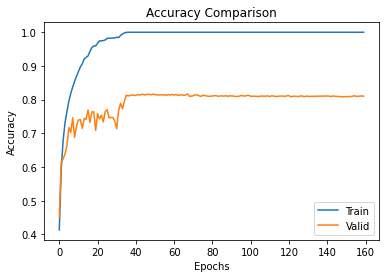

In [15]:
import matplotlib.pyplot as plt
plt.plot(torch.stack(train_tot_accs).cpu().detach().numpy(), label="Train")
plt.plot(torch.stack(valid_tot_accs).cpu().detach().numpy(), label="Valid")
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

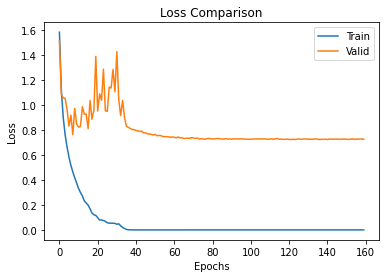

In [16]:

plt.plot(torch.stack(train_tot_losses).cpu().detach().numpy(), label="Train")
plt.plot(torch.stack(valid_tot_losses).cpu().detach().numpy(), label="Valid")
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
test_accs = []
test_losses = []

for idx, batch in enumerate(testloader):
    data, target = batch
    data = data.to(device=device)
    labels = F.one_hot(target, num_classes = 10).float().to(device=device)
    acc, loss = Model.evaluation(data,labels)
    test_accs.append(acc)
    test_losses.append(loss)
        
test_tot_accs = (sum(test_accs)/len(test_accs))
test_tot_losses = (sum(test_losses)/len(test_losses))
            
# logging.info(f"==========Test Accuracy: {test_tot_accs:.3f} , Test Loss: {test_tot_losses:.3f}==========") 
print(f"==========Test Accuracy: {test_tot_accs:.3f} , Test Loss: {test_tot_losses:.3f}==========")  

==========Test Accuracy: 0.807 , Test Loss: 0.718==========


In [18]:
if not os.path.exists(f"./src/Evaluation/Logs/{config_name}"):
    os.makedirs(f"./src/Evaluation/Logs/{config_name}")
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_train_acc.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in train_tot_accs))
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_train_loss.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in train_tot_losses))
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_valid_acc.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in valid_tot_accs))
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_valid_loss.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in valid_tot_losses))
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_test_acc.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in [test_tot_accs]))
with open(f"./src/Evaluation/Logs/{config_name}/{config_name}_test_loss.txt", "w") as f:
        f.write("\n".join(str(item.cpu().detach().numpy()) for item in [test_tot_losses]))

In [19]:
# pickle_path = f"./Model/{args.config_file}.pickle"

if not os.path.exists(f"./src/Model/{model_file}"):
    os.makedirs(f"./src/Model/{model_file}")
pickle_path = f"./src/Model/{model_file}/{config_name}.pickle"
logging.info("Saving model to pickle file")
with open(pickle_path, "wb") as f:
  pickle.dump(Model, f, pickle.HIGHEST_PROTOCOL)





INFO:root:Saving model to pickle file
